In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

# Import Data

In [3]:
df = pd.read_csv("data/taxi_fare.csv", parse_dates=["pickup_datetime"])
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1.0
1,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1.0
2,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2.0
3,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1.0
4,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1.0


In [4]:
df.dropna(inplace=True)

In [5]:
pickup_dt = df.pickup_datetime.dt

In [6]:
df['year'] = pickup_dt.year
df['month'] = pickup_dt.month
df['day'] = pickup_dt.dayofweek
df['hour'] = pickup_dt.hour
df.drop(columns="pickup_datetime", inplace=True)
df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1.0,2009,6,0,17
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1.0,2010,1,1,16
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2.0,2011,8,3,0
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1.0,2012,4,5,4
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1.0,2010,3,1,7


In [7]:
df['distance'] = np.abs(df.pickup_longitude - df.dropoff_longitude) + np.abs(df.pickup_latitude - df.dropoff_latitude)
df.drop(columns=['pickup_longitude', 'dropoff_longitude', 'pickup_latitude', 'dropoff_latitude'], inplace=True)
df.head()

,fare_amount,passenger_count,year,month,day,hour,distance
0,4.5,1.0,2009,6,0,17,0.011742
1,16.9,1.0,2010,1,1,16,0.107481
2,5.7,2.0,2011,8,3,0,0.019212
3,7.7,1.0,2012,4,5,4,0.029386
4,5.3,1.0,2010,3,1,7,0.027194


# Dataset 

In [8]:
X = df.drop(columns="fare_amount")
y = df.fare_amount

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((15134, 6), (3784, 6), (15134,), (3784,))

In [10]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

In [14]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(poly=2, transform='yeo-johnson'), ['passenger_count', 'year', 'distance']),
    ('categoric', cat_pipe(encoder='onehot'), ['month', 'day', 'hour']),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', ElasticNet())
])

model = RandomizedSearchCV(pipeline, rsp.enet_poly_params, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   20.9s finished
C:\Users\HP 14\Miniconda3\envs\jcopml\lib\site-packages\sklearn\preprocessing\_data.py:2970: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


{'algo__alpha': 0.00012575549573395252, 'algo__fit_intercept': True, 'algo__l1_ratio': 0.8095010461397156, 'prep__numeric__poly__degree': 3, 'prep__numeric__poly__interaction_only': False}
0.7195136116796721 0.7160608685636406 0.7467155093396689


C:\Users\HP 14\Miniconda3\envs\jcopml\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 177372.87394032025, tolerance: 140.34017623508723
  positive)


# Feature Importance

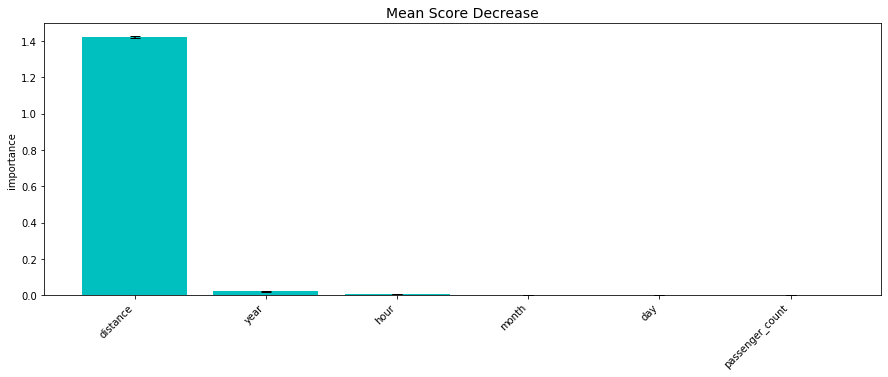

In [15]:
df_imp = mean_score_decrease(X_train, y_train, model, plot=True, topk=10)

# Evaluation

In [16]:
from jcopml.plot import plot_residual

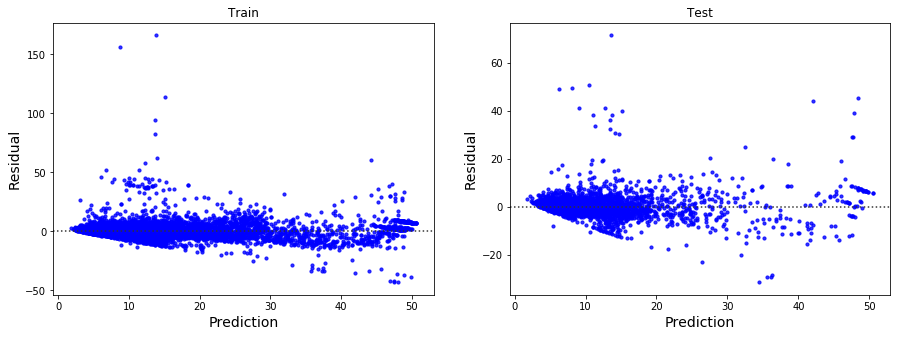

In [17]:
plot_residual(X_train, y_train, X_test, y_test, model)

### masih saja ada data unbalanced, mari kita cek datanya

In [18]:
df_analysis = X_train.copy()

In [22]:
pred = model.predict(X_train)
error = np.abs(pred - y_train)

df_analysis['fare'] = y_train
df_analysis['error'] = error
df_analysis.sort_values("error", ascending=False).head(100)

,passenger_count,year,month,day,hour,distance,fare,error
1335,1.0,2013,1,2,20,0.000000,180.00,166.122791
1483,1.0,2009,8,4,21,0.000416,165.00,156.266630
6630,1.0,2014,5,4,1,0.000000,128.83,113.742022
14142,1.0,2014,12,4,10,0.045860,108.00,94.340081
12915,1.0,2011,9,2,1,0.000000,96.00,82.253870
...,...,...,...,...,...,...,...,...
649,2.0,2009,9,5,10,0.551623,66.30,26.131721
15023,2.0,2011,8,2,7,0.327136,73.30,25.742891
10111,1.0,2012,9,2,19,0.130128,2.50,25.064576
13013,2.0,2015,2,4,19,0.000000,39.83,25.052532


In [21]:
df[df.fare_amount<0]

,fare_amount,passenger_count,year,month,day,hour,distance
2039,-2.9,1.0,2010,3,1,23,0.002331
2486,-2.5,1.0,2015,3,6,5,0.000313
13032,-3.0,4.0,2013,8,4,8,0.001425
